In [1]:
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
import classifier
import debias
#import debias_old as debias
import gensim
import codecs
import json
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier, Perceptron, LogisticRegression, PassiveAggressiveClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import scipy
from scipy import linalg
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
# matplotlib.rcParams['agg.path.chunksize'] = 10000
from sklearn.utils import shuffle

# import warnings
# warnings.filterwarnings("ignore")
# %load_ext autoreload
# %autoreload

from collections import Counter, defaultdict
import seaborn as sns
# sns.set_style("whitegrid")

# Function

In [2]:
def load_data(path, size, ratio=0.5):
    fnames = ["neg_neg.npy", "neg_pos.npy", "pos_neg.npy", "pos_pos.npy"]
    protected_labels = [0, 1, 0, 1]
    main_labels = [0, 0, 1, 1]
    X, Y_p, Y_m = [], [], []
    n1 = int(size * ratio / 2)
    n2 = int(size * (1 - ratio) / 2)
#     print(n1, n2)

    for fname, p_label, m_label, n in zip(fnames, protected_labels, main_labels, [n1, n2, n2, n1]):
#         print(path + '/' + fname)
#         print(np.load(path + '/' + fname).shape)
        data = np.load(path + '/' + fname)[:n]
        for x in data:
            X.append(x)
        for _ in data:
            Y_p.append(p_label)
        for _ in data:
            Y_m.append(m_label)

    Y_p = np.array(Y_p)
    Y_m = np.array(Y_m)
    X = np.array(X)
    X, Y_p, Y_m = shuffle(X, Y_p, Y_m, random_state=0)
    return X, Y_p, Y_m

In [3]:
def get_TPR(y_main, y_hat_main, y_protected):
    
    all_y = list(Counter(y_main).keys())
    
    protected_vals = defaultdict(dict)
    for label in all_y:
        for i in range(2):
            used_vals = (y_main == label) & (y_protected == i)
            y_label = y_main[used_vals]
            y_hat_label = y_hat_main[used_vals]
            protected_vals['y:{}'.format(label)]['p:{}'.format(i)] = (y_label == y_hat_label).mean()
            
    diffs = {}
    for k, v in protected_vals.items():
        vals = list(v.values())
        diffs[k] = vals[0] - vals[1]
    return protected_vals, diffs

In [4]:
def rms(arr):
    return np.sqrt(np.mean(np.square(arr)))

In [5]:
def calc_plot_tpr(P):
    
    results = defaultdict(dict)
    for ratio in [0.5, 0.6, 0.7, 0.8]:

        x_train, y_p_train, y_m_train = load_data(
            '../data/emoji_sent_race_{}/train/'.format(ratio),
            size=100000, ratio=ratio)
        x_dev, y_p_dev, y_m_dev = load_data(
            '../data/emoji_sent_race_{}/test/'.format(ratio),
            size=100000, ratio=0.5)

        biased_classifier = LinearSVC(fit_intercept=True, class_weight='balanced', dual=False, C=0.1, max_iter=10000)

        biased_classifier.fit(x_train, y_m_train)
        biased_score = biased_classifier.score(x_dev, y_m_dev)

    #     P = np.load('../data/emoji_sent_race_{}/P_svm.num-clfs=300.npy'.format(ratio), allow_pickle=True)
    #     P = P[1]

    #     n_dims = 120
    # #     n_dims = 70
    #     if ratio == 0.5:
    #         n_dims = 200
    #     elif ratio == 0.6:
    #         n_dims = 100
    #     elif ratio == 0.7:
    #         n_dims = 115
    #     elif ratio == 0.8:
    #         n_dims = 200

    #     P = debias.get_projection_to_intersection_of_nullspaces(P[:n_dims], input_dim=300)

        debiased_x_train = P.dot(x_train.T).T
        debiased_x_dev = P.dot(x_dev.T).T

        classifier = LinearSVC(fit_intercept=True, class_weight='balanced', dual=False, C=0.1, max_iter=10000)

        classifier.fit(debiased_x_train, y_m_train)
        debiased_score = classifier.score(debiased_x_dev, y_m_dev)

        p_classifier = SGDClassifier(warm_start=True, loss='log', n_jobs=64, max_iter=10000, random_state=0, tol=1e-3)
        p_classifier.fit(debiased_x_train, y_p_train)
        p_score = p_classifier.score(debiased_x_dev, y_p_dev)
        results[ratio]['p_acc'] = p_score

        _, biased_diffs = get_TPR(y_m_dev, biased_classifier.predict(x_dev), y_p_dev)

        _, debiased_diffs = get_TPR(y_m_dev, classifier.predict(debiased_x_dev), y_p_dev)

    #     results[ratio]['biased_diff_tpr'] = biased_diffs['y:0']
        results[ratio]['biased_diff_tpr'] = rms(list(biased_diffs.values()))
    #     results[ratio]['debiased_diff_tpr'] = debiased_diffs['y:0']
        results[ratio]['debiased_diff_tpr'] = rms(list(debiased_diffs.values()))

        results[ratio]['biased_acc'] = biased_score
        results[ratio]['debiased_acc'] = debiased_score

    plot_results = defaultdict(list)
    for r in [0.5, 0.6, 0.7, 0.8]:
        plot_results['biased_diff_tpr'].append(results[r]['biased_diff_tpr'])
        plot_results['debiased_diff_tpr'].append(results[r]['debiased_diff_tpr'])
        plot_results['biased_acc'].append(results[r]['biased_acc'])
        plot_results['debiased_acc'].append(results[r]['debiased_acc'])

    return results, plot_results

In [6]:
def data2plot(results, removal_range):
    x = removal_range

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('ratio')
    ax1.set_ylabel('diff tpr', color=color)
    ax1.plot(x, results['biased_diff_tpr'], '.--', label='biased tpr diff', color=color)
    ax1.plot(x, results['debiased_diff_tpr'], '*:', label='debiased tpr diff', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    plt.ylim(0.,0.6)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('acc', color=color)  # we already handled the x-label with ax1
    ax2.plot(x, results['biased_acc'], '^-', label='biased acc', color=color)
    ax2.plot(x, results['debiased_acc'], 'o--', label='debiased acc', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    # ask matplotlib for the plotted objects and their labels
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines, labels, loc='lower right')
    
    from matplotlib.legend import Legend
    leg = Legend(ax2, lines2, labels2,
             loc='upper left', frameon=False)
    ax2.add_artist(leg);

    plt.title('TPR rates as a function of the ratio')
    plt.ylim(0.5,.85)
#     plt.legend()
#     plt.savefig('tpr_rates_ratio.png', dpi=1000)
    plt.show()
    
# data2plot(plot_results)

# Cross-validate

In [7]:
def check_result(u, removel_range, x_train, x_dev, y_m_train, y_m_dev, y_p_train, y_p_dev):
    results = defaultdict(dict)

    biased_classifier = LinearSVC(fit_intercept=True, class_weight='balanced', dual=False, C=0.1, max_iter=10000)

    biased_classifier.fit(x_train, y_m_train)
    biased_score = biased_classifier.score(x_dev, y_m_dev)
    _, biased_diffs = get_TPR(y_m_dev, biased_classifier.predict(x_dev), y_p_dev)
    
    for removal in removel_range:
        u_r = u[:, removal:]
        proj = u_r @ u_r.T
        P = proj

        debiased_x_train = P.dot(x_train.T).T
        debiased_x_dev = P.dot(x_dev.T).T

        classifier = LinearSVC(fit_intercept=True, class_weight='balanced', dual=False, C=0.1, max_iter=10000)

        classifier.fit(debiased_x_train, y_m_train)
        debiased_score = classifier.score(debiased_x_dev, y_m_dev)

        p_classifier = SGDClassifier(warm_start=True, loss='log', n_jobs=64, max_iter=10000, random_state=0, tol=1e-3)
        p_classifier.fit(debiased_x_train, y_p_train)
        p_score = p_classifier.score(debiased_x_dev, y_p_dev)

        _, debiased_diffs = get_TPR(y_m_dev, classifier.predict(debiased_x_dev), y_p_dev)


        results[removal]['p_acc'] = p_score
        #     results[ratio]['biased_diff_tpr'] = biased_diffs['y:0']
        results[removal]['biased_diff_tpr'] = rms(list(biased_diffs.values()))
        #     results[ratio]['debiased_diff_tpr'] = debiased_diffs['y:0']
        results[removal]['debiased_diff_tpr'] = rms(list(debiased_diffs.values()))

        results[removal]['biased_acc'] = biased_score
        results[removal]['debiased_acc'] = debiased_score
        
    return results

In [8]:
def check_result_ksal(x_train, x_test, y_m_train, y_m_test, y_p_train, y_p_test, debiased_x_train_all, debiased_x_test_all):
    
    results = defaultdict(dict)

    biased_classifier = LinearSVC(fit_intercept=True, class_weight='balanced', dual=False, C=0.1, max_iter=10000)

    biased_classifier.fit(x_train, y_m_train)
    biased_score = biased_classifier.score(x_test, y_m_test)
    _, biased_diffs = get_TPR(y_m_test, biased_classifier.predict(x_test), y_p_test)
    
    assert len(debiased_x_train_all) == len(debiased_x_test_all)
    
    for removal in range(len(debiased_x_train_all)):
        debiased_x_train = debiased_x_train_all[removal]
        debiased_x_test = debiased_x_test_all[removal]
        
        classifier = LinearSVC(fit_intercept=True, class_weight='balanced', dual=False, C=0.1, max_iter=10000)
        classifier.fit(debiased_x_train, y_m_train)
        debiased_score = classifier.score(debiased_x_test, y_m_test)
    
        p_classifier = SGDClassifier(warm_start=True, loss='log', n_jobs=64, max_iter=10000, random_state=0, tol=1e-3)
        p_classifier.fit(debiased_x_train, y_p_train)
        p_score = p_classifier.score(debiased_x_test, y_p_test)
        _, debiased_diffs = get_TPR(y_m_test, classifier.predict(debiased_x_test), y_p_test)

        results[removal]['p_acc'] = p_score
        results[removal]['biased_diff_tpr'] = rms(list(biased_diffs.values()))
        results[removal]['debiased_diff_tpr'] = rms(list(debiased_diffs.values()))
        results[removal]['biased_acc'] = biased_score
        results[removal]['debiased_acc'] = debiased_score
        
    return results

In [9]:
def convert_to_plot_results(results, removel_range):
    plot_results = defaultdict(list)
    for r in removel_range:
        plot_results['biased_diff_tpr'].append(results[r]['biased_diff_tpr'])
        plot_results['debiased_diff_tpr'].append(results[r]['debiased_diff_tpr'])
        plot_results['biased_acc'].append(results[r]['biased_acc'])
        plot_results['debiased_acc'].append(results[r]['debiased_acc'])
    return plot_results

In [10]:
# ratio = 0.5

# x_train, y_p_train, y_m_train = load_data(
#     '../data/emoji_sent_race_{}/train/'.format(ratio),
#     size=100000, ratio=ratio)
# x_dev, y_p_dev, y_m_dev = load_data(
#     '../data/emoji_sent_race_{}/test/'.format(ratio),
#     size=100000, ratio=0.5)
# np.savetxt(f"../data/saved_models/fair_emoji_sent_race/{ratio}/x_train.csv", x_train, delimiter=",")
# np.savetxt(f"../data/saved_models/fair_emoji_sent_race/{ratio}/y_p_train.csv", y_p_train, delimiter=",")
# np.savetxt(f"../data/saved_models/fair_emoji_sent_race/{ratio}/y_m_train.csv", y_m_train, delimiter=",")
# np.savetxt(f"../data/saved_models/fair_emoji_sent_race/{ratio}/x_dev.csv", x_dev, delimiter=",")
# np.savetxt(f"../data/saved_models/fair_emoji_sent_race/{ratio}/y_p_dev.csv", y_p_dev, delimiter=",")
# np.savetxt(f"../data/saved_models/fair_emoji_sent_race/{ratio}/y_m_dev.csv", y_m_dev, delimiter=",")
# np.savez(f"../data/saved_models/fair_emoji_sent_race/{ratio}/all.npz", x_train = x_train, y_p_train = y_p_train, y_m_train = y_m_train, x_dev = x_dev, y_p_dev = y_p_dev, y_m_dev = y_m_dev)

# Null it out

In [10]:
# ratio = 0.5

# saved_dataset = np.load(f"../data/saved_models/fair_emoji_sent_race/{ratio}/all.npz")

# x_train = saved_dataset['x_train']
# y_m_train = saved_dataset['y_m_train']
# y_p_train = saved_dataset['y_p_train']

# x_dev = saved_dataset['x_dev']
# y_p_dev = saved_dataset['y_p_dev']
# y_m_dev = saved_dataset['y_m_dev']

In [12]:
results = defaultdict(dict)

for ratio in [0.5, 0.6, 0.7, 0.8]:

#     x_train, y_p_train, y_m_train = load_data(
#         '../data/emoji_sent_race_{}/train/'.format(ratio),
#         size=100000, ratio=ratio)
#     x_dev, y_p_dev, y_m_dev = load_data(
#         '../data/emoji_sent_race_{}/test/'.format(ratio),
#         size=100000, ratio=0.5)
    saved_dataset = np.load(f"../data/saved_models/fair_emoji_sent_race/{ratio}/all.npz")

    x_train = saved_dataset['x_train']
    y_m_train = saved_dataset['y_m_train']
    y_p_train = saved_dataset['y_p_train']

    x_dev = saved_dataset['x_dev']
    y_p_dev = saved_dataset['y_p_dev']
    y_m_dev = saved_dataset['y_m_dev']
    
    biased_classifier = LinearSVC(fit_intercept=True, class_weight='balanced', dual=False, C=0.1, max_iter=10000)

    biased_classifier.fit(x_train, y_m_train)
    biased_score = biased_classifier.score(x_dev, y_m_dev)
    
    P = np.load('../data/emoji_sent_race_{}/P_svm.num-clfs=300.npy'.format(ratio), allow_pickle=True)
    P = P[1]
    n_dims = 120
#     n_dims = 70
    if ratio == 0.5:
        n_dims = 200
    elif ratio == 0.6:
        n_dims = 100
    elif ratio == 0.7:
        n_dims = 115
    elif ratio == 0.8:
        n_dims = 200
    P = debias.get_projection_to_intersection_of_nullspaces(P[:n_dims], input_dim=300)
    
    debiased_x_train = P.dot(x_train.T).T
    debiased_x_dev = P.dot(x_dev.T).T

    classifier = LinearSVC(fit_intercept=True, class_weight='balanced', dual=False, C=0.1, max_iter=10000)

    classifier.fit(debiased_x_train, y_m_train)
    debiased_score = classifier.score(debiased_x_dev, y_m_dev)
    
    p_classifier = SGDClassifier(warm_start=True, loss='log', n_jobs=64, max_iter=10000, random_state=0, tol=1e-3)
    p_classifier.fit(debiased_x_train, y_p_train)
    p_score = p_classifier.score(debiased_x_dev, y_p_dev)
    results[ratio]['p_acc'] = p_score
    
    _, biased_diffs = get_TPR(y_m_dev, biased_classifier.predict(x_dev), y_p_dev)
    
    _, debiased_diffs = get_TPR(y_m_dev, classifier.predict(debiased_x_dev), y_p_dev)
    
#     results[ratio]['biased_diff_tpr'] = biased_diffs['y:0']
    results[ratio]['biased_diff_tpr'] = rms(list(biased_diffs.values()))
#     results[ratio]['debiased_diff_tpr'] = debiased_diffs['y:0']
    results[ratio]['debiased_diff_tpr'] = rms(list(debiased_diffs.values()))
    
    results[ratio]['biased_acc'] = biased_score
    results[ratio]['debiased_acc'] = debiased_score

In [13]:
results

defaultdict(dict,
            {0.5: {'p_acc': 0.5396349087271818,
              'biased_diff_tpr': 0.14560632483708713,
              'debiased_diff_tpr': 0.11974302439852863,
              'biased_acc': 0.7653163290822705,
              'debiased_acc': 0.7625656414103525},
             0.6: {'p_acc': 0.5946486621655414,
              'biased_diff_tpr': 0.22630502371727185,
              'debiased_diff_tpr': 0.19067232927585404,
              'biased_acc': 0.7531882970742686,
              'debiased_acc': 0.7579394848712178},
             0.7: {'p_acc': 0.6257814453613403,
              'biased_diff_tpr': 0.31864557675474753,
              'debiased_diff_tpr': 0.26266284955843594,
              'biased_acc': 0.741185296324081,
              'debiased_acc': 0.7478119529882471},
             0.8: {'p_acc': 0.5043760940235059,
              'biased_diff_tpr': 0.4043010400370602,
              'debiased_diff_tpr': 0.010947167516829342,
              'biased_acc': 0.7200550137534384,
      

In [14]:
plot_results = defaultdict(list)
for r in [0.5, 0.6, 0.7, 0.8]:
    plot_results['biased_diff_tpr'].append(results[r]['biased_diff_tpr'])
    plot_results['debiased_diff_tpr'].append(results[r]['debiased_diff_tpr'])
    plot_results['biased_acc'].append(results[r]['biased_acc'])
    plot_results['debiased_acc'].append(results[r]['debiased_acc'])
plot_results

defaultdict(list,
            {'biased_diff_tpr': [0.14560632483708713,
              0.22630502371727185,
              0.31864557675474753,
              0.4043010400370602],
             'debiased_diff_tpr': [0.11974302439852863,
              0.19067232927585404,
              0.26266284955843594,
              0.010947167516829342],
             'biased_acc': [0.7653163290822705,
              0.7531882970742686,
              0.741185296324081,
              0.7200550137534384],
             'debiased_acc': [0.7625656414103525,
              0.7579394848712178,
              0.7478119529882471,
              0.5290072518129533]})

# KSAL

We recommend you to use the code in src/ksal, coz it took very long time and large memory to calculated the debiased_x by ksal

In [10]:
N = 15000
N_test = 7998

# 1.Ratio = 0.5

In [11]:
ratio = 0.5
saved_dataset = np.load(f"../data/saved_models/fair_emoji_sent_race/{ratio}/all.npz")

x_train = saved_dataset['x_train']
y_m_train = saved_dataset['y_m_train']
y_p_train = saved_dataset['y_p_train']

x_test = saved_dataset['x_dev']
y_p_test = saved_dataset['y_p_dev']
y_m_test = saved_dataset['y_m_dev']

## 1.1 Linear Kernel

In [12]:
kernel_fn = "linear"
kernel_coef = 0

saved_model = np.load(f"../data/saved_models/fair_emoji_sent_race/{ratio}/cleaned_{kernel_fn}_{kernel_coef}_Train{N}_Test{N_test}.npz")
debiased_x_train_0 = saved_model['debiased_x_train_0']
debiased_x_test_0 = saved_model['debiased_x_test_0']
debiased_x_train_1 = saved_model['debiased_x_train_1']
debiased_x_test_1 = saved_model['debiased_x_test_1']
debiased_x_train_2 = saved_model['debiased_x_train_2']
debiased_x_test_2 = saved_model['debiased_x_test_2']


debiased_x_train_all = [debiased_x_train_0, debiased_x_train_1, debiased_x_train_2]
debiased_x_test_all = [debiased_x_test_0, debiased_x_test_1, debiased_x_test_2]

removel_range = np.arange(0, len(debiased_x_train_all))
removel_range


array([0, 1, 2])

In [13]:
results = check_result_ksal(x_train[:N], x_test[:N_test], y_m_train[:N], y_m_test[:N_test], y_p_train[:N], y_p_test[:N_test], \
                      debiased_x_train_all, debiased_x_test_all)
results

defaultdict(dict,
            {0: {'p_acc': 0.8698424606151538,
              'biased_diff_tpr': 0.1502091848184275,
              'debiased_diff_tpr': 0.1504968261279982,
              'biased_acc': 0.7619404851212803,
              'debiased_acc': 0.7616904226056515},
             1: {'p_acc': 0.8615903975993998,
              'biased_diff_tpr': 0.1502091848184275,
              'debiased_diff_tpr': 0.15201284243714744,
              'biased_acc': 0.7619404851212803,
              'debiased_acc': 0.7616904226056515},
             2: {'p_acc': 0.48637159289822457,
              'biased_diff_tpr': 0.1502091848184275,
              'debiased_diff_tpr': 0.10883716039415621,
              'biased_acc': 0.7619404851212803,
              'debiased_acc': 0.7639409852463116}})

In [14]:
plot_results = convert_to_plot_results(results, removel_range)
plot_results

defaultdict(list,
            {'biased_diff_tpr': [0.1502091848184275,
              0.1502091848184275,
              0.1502091848184275],
             'debiased_diff_tpr': [0.1504968261279982,
              0.15201284243714744,
              0.10883716039415621],
             'biased_acc': [0.7619404851212803,
              0.7619404851212803,
              0.7619404851212803],
             'debiased_acc': [0.7616904226056515,
              0.7616904226056515,
              0.7639409852463116]})

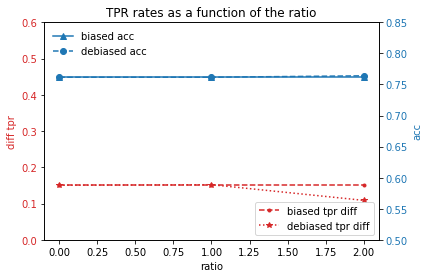

In [15]:
data2plot(plot_results, removel_range)

## 1.2 RBF kernel at gamma = 0.1

In [17]:
kernel_fn = "rbf"
kernel_coef = 0.1

saved_model = np.load(f"../data/saved_models/fair_emoji_sent_race/{ratio}/cleaned_{kernel_fn}_{kernel_coef}_Train{N}_Test{N_test}.npz")
debiased_x_train_0 = saved_model['debiased_x_train_0']
debiased_x_test_0 = saved_model['debiased_x_test_0']
debiased_x_train_1 = saved_model['debiased_x_train_1']
debiased_x_test_1 = saved_model['debiased_x_test_1']
debiased_x_train_2 = saved_model['debiased_x_train_2']
debiased_x_test_2 = saved_model['debiased_x_test_2']


debiased_x_train_all = [debiased_x_train_0, debiased_x_train_1, debiased_x_train_2]
debiased_x_test_all = [debiased_x_test_0, debiased_x_test_1, debiased_x_test_2]

removel_range = np.arange(0, len(debiased_x_train_all))
removel_range


array([0, 1, 2])

In [18]:
results = check_result_ksal(x_train[:N], x_test[:N_test], y_m_train[:N], y_m_test[:N_test], y_p_train[:N], y_p_test[:N_test], \
                      debiased_x_train_all, debiased_x_test_all)
results

defaultdict(dict,
            {0: {'p_acc': 0.8448362090522631,
              'biased_diff_tpr': 0.1502091848184275,
              'debiased_diff_tpr': 0.15173285176162127,
              'biased_acc': 0.7619404851212803,
              'debiased_acc': 0.7634408602150538},
             1: {'p_acc': 0.8442110527631908,
              'biased_diff_tpr': 0.1502091848184275,
              'debiased_diff_tpr': 0.15103294642036444,
              'biased_acc': 0.7619404851212803,
              'debiased_acc': 0.7641910477619405},
             2: {'p_acc': 0.49987496874218557,
              'biased_diff_tpr': 0.1502091848184275,
              'debiased_diff_tpr': 0.12146052772714196,
              'biased_acc': 0.7619404851212803,
              'debiased_acc': 0.7651912978244562}})

In [19]:
plot_results = convert_to_plot_results(results, removel_range)
plot_results

defaultdict(list,
            {'biased_diff_tpr': [0.1502091848184275,
              0.1502091848184275,
              0.1502091848184275],
             'debiased_diff_tpr': [0.15173285176162127,
              0.15103294642036444,
              0.12146052772714196],
             'biased_acc': [0.7619404851212803,
              0.7619404851212803,
              0.7619404851212803],
             'debiased_acc': [0.7634408602150538,
              0.7641910477619405,
              0.7651912978244562]})

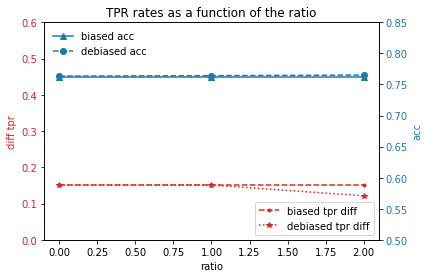

In [20]:
data2plot(plot_results, removel_range)

## 1.3 Polynomial kernel at degree=2

In [12]:
kernel_fn = "poly"
kernel_coef = 2

saved_model = np.load(f"../data/saved_models/fair_emoji_sent_race/{ratio}/cleaned_{kernel_fn}_{kernel_coef}_Train{N}_Test{N_test}.npz")
debiased_x_train_0 = saved_model['debiased_x_train_0']
debiased_x_test_0 = saved_model['debiased_x_test_0']
debiased_x_train_1 = saved_model['debiased_x_train_1']
debiased_x_test_1 = saved_model['debiased_x_test_1']
debiased_x_train_2 = saved_model['debiased_x_train_2']
debiased_x_test_2 = saved_model['debiased_x_test_2']


debiased_x_train_all = [debiased_x_train_0, debiased_x_train_1, debiased_x_train_2]
debiased_x_test_all = [debiased_x_test_0, debiased_x_test_1, debiased_x_test_2]

removel_range = np.arange(0, len(debiased_x_train_all))
removel_range


array([0, 1, 2])

In [13]:
results = check_result_ksal(x_train[:N], x_test[:N_test], y_m_train[:N], y_m_test[:N_test], y_p_train[:N], y_p_test[:N_test], \
                      debiased_x_train_all, debiased_x_test_all)
results

defaultdict(dict,
            {0: {'p_acc': 0.865216304076019,
              'biased_diff_tpr': 0.1502091848184275,
              'debiased_diff_tpr': 0.14451395083761795,
              'biased_acc': 0.7619404851212803,
              'debiased_acc': 0.7509377344336085},
             1: {'p_acc': 0.8643410852713178,
              'biased_diff_tpr': 0.1502091848184275,
              'debiased_diff_tpr': 0.14486564891478834,
              'biased_acc': 0.7619404851212803,
              'debiased_acc': 0.750812703175794},
             2: {'p_acc': 0.4441110277569392,
              'biased_diff_tpr': 0.1502091848184275,
              'debiased_diff_tpr': 0.13027443128532498,
              'biased_acc': 0.7619404851212803,
              'debiased_acc': 0.7504376094023506}})

In [14]:
plot_results = convert_to_plot_results(results, removel_range)
plot_results

defaultdict(list,
            {'biased_diff_tpr': [0.1502091848184275,
              0.1502091848184275,
              0.1502091848184275],
             'debiased_diff_tpr': [0.14451395083761795,
              0.14486564891478834,
              0.13027443128532498],
             'biased_acc': [0.7619404851212803,
              0.7619404851212803,
              0.7619404851212803],
             'debiased_acc': [0.7509377344336085,
              0.750812703175794,
              0.7504376094023506]})

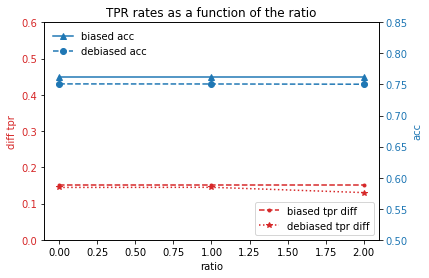

In [15]:
data2plot(plot_results, removel_range)

## 1.4 Polynomial kernel at degree=5

In [16]:
kernel_fn = "poly"
kernel_coef = 5

saved_model = np.load(f"../data/saved_models/fair_emoji_sent_race/{ratio}/cleaned_{kernel_fn}_{kernel_coef}_Train{N}_Test{N_test}.npz")
debiased_x_train_0 = saved_model['debiased_x_train_0']
debiased_x_test_0 = saved_model['debiased_x_test_0']
debiased_x_train_1 = saved_model['debiased_x_train_1']
debiased_x_test_1 = saved_model['debiased_x_test_1']
debiased_x_train_2 = saved_model['debiased_x_train_2']
debiased_x_test_2 = saved_model['debiased_x_test_2']


debiased_x_train_all = [debiased_x_train_0, debiased_x_train_1, debiased_x_train_2]
debiased_x_test_all = [debiased_x_test_0, debiased_x_test_1, debiased_x_test_2]

removel_range = np.arange(0, len(debiased_x_train_all))
removel_range


array([0, 1, 2])

In [ ]:
results = check_result_ksal(x_train[:N], x_test[:N_test], y_m_train[:N], y_m_test[:N_test], y_p_train[:N], y_p_test[:N_test], \
                      debiased_x_train_all, debiased_x_test_all)
results

In [ ]:
plot_results = convert_to_plot_results(results, removel_range)
plot_results

In [ ]:
data2plot(plot_results, removel_range)